# Imports Library

In [1]:
import numpy as np 
import pandas as pd 
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import BatchNormalization, RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from numpy import expand_dims
import wandb
from wandb.keras import WandbCallback
import warnings
warnings.filterwarnings('ignore')

# Define Data Paths and Load Training Data

In [2]:
test_path = 'histopathologic-cancer-detection/test/'
train_path = 'histopathologic-cancer-detection/train/'
train_data = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [4]:
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
print(f'Number of files in test directory: {len(os.listdir(test_path))}')
print(f'Number of files in train directory: {len(os.listdir(train_path))}')

Number of files in test directory: 57458
Number of files in train directory: 220025


# Data Visualization

In [6]:
sample_tumor_ids = train_data[train_data['label'] == 1]['id'].sample(n=3).values
sample_normal_ids = train_data[train_data['label'] == 0]['id'].sample(n=3).values

In [7]:
tumor_images = []
for id in sample_tumor_ids:
    image_path = os.path.join(train_path, id + '.tif')
    tumor_images.append(Image.open(image_path))
    
    
normal_images = []
for id in sample_normal_ids:
    image_path = os.path.join(train_path, id + '.tif')
    normal_images.append(Image.open(image_path))

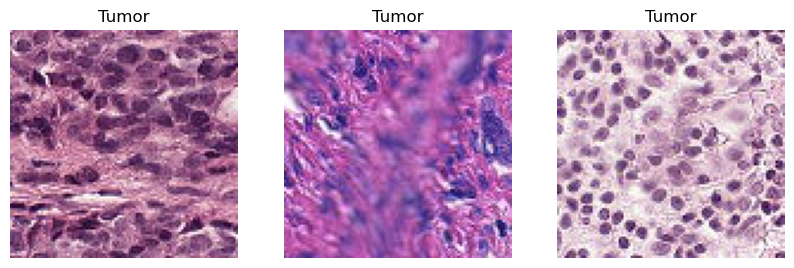

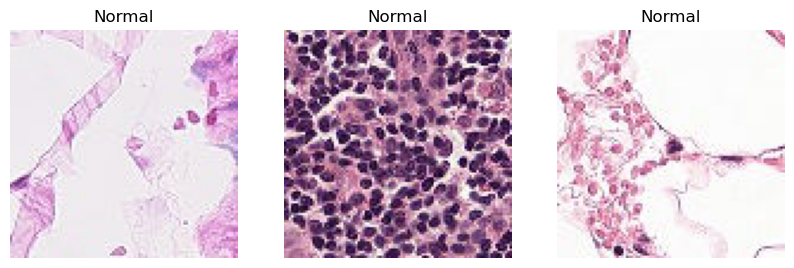

In [8]:
plt.figure(figsize=(10, 3))
for i, image in enumerate(tumor_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Tumor')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 3))
for i, image in enumerate(normal_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Normal')
    plt.axis('off')
plt.show()

# Preprocess Training Data

In [9]:
train_data['id'] = train_data['id'].apply(lambda x: x + '.tif')
train_data['label'] = train_data['label'].astype(str)

In [10]:
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.3)

# Data Generators for Training and Validation

In [11]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=128,
    seed=13,
    class_mode="binary",
    target_size=(32, 32),
    shuffle=True)

Found 154018 validated image filenames belonging to 2 classes.


In [12]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=128,
    seed=13,
    class_mode="binary",
    target_size=(32, 32),
    shuffle=True)

Found 66007 validated image filenames belonging to 2 classes.


# Training the model and tuning hyperparameters:

In [22]:
sweep_config = {
    'method': 'bayes'
}

In [23]:
metric = {
      'goal': 'maximize',
      'name': 'accuracy'
  }
    
sweep_config['metric'] = metric

parameter_dict = { 'batch_size': {
                        'values' : [16, 32, 64, 128]},
                  'learning_rate': { 
                      'distribution': 'uniform',
                      'max': 0.01,
                      'min': 0.0001},
                  'epochs': {
                      'distribution': 'int_uniform',
                      'max': 10,
                      'min': 5 },
                  'optimizer': {
                      'values':['adam', 'sgd']},
                  'fc_layer_size': {
                      'values' : [16, 32, 64]},
                  'dropout': {
                      'values' : [0.1, 0.2, 0.3]}
    }
sweep_config['parameters'] = parameter_dict

In [24]:
sweep_id = wandb.sweep(sweep_config, project = 'histopathologic_cancer_detection')

Create sweep with ID: ilrmjuzt
Sweep URL: https://wandb.ai/rebu/histopathologic_cancer_detection/sweeps/ilrmjuzt


In [25]:
# Defining the train function for iterations
def train():
    # Initializing the wandb
    run = wandb.init(project = 'histopathologic-cancer-detection',
                     config = {'epochs': 10,
                               'learning_rate': 0.001,
                               'batch_size': 64,
                               'optimizer':'adam',
                               'fc_layer_size':128,
                               'dropout':0.3
                             })
    config = wandb.config
    
    model = create_model(config.fc_layer_size, config.dropout)
    optimizer = create_optimizer(config.optimizer, config.learning_rate)
    
    # Compiling the model
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Model training
    _ = model.fit(train_generator,
             epochs = config.epochs,
             batch_size = config.batch_size,
             validation_data = valid_generator,
             callbacks = [WandbCallback(data_type = 'image',
                                       training_data = train_generator,
                                       labels = "label")])

In [26]:
def create_model(fc_layer_size, dropout):
    
    # Creating the CNN model
    model = Sequential()
    reg = l2(0.001)  

    model.add(Conv2D(16, (3,3), activation='relu', kernel_regularizer=reg, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Conv2D(16, (3,3), kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3,3), kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(fc_layer_size, activation = 'relu'))
    model.add(Dense(1, activation="sigmoid", kernel_regularizer=reg))
    
    return model

In [27]:
def create_optimizer(optimizer, learning_rate):
    if optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate = learning_rate)        
    else:
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
        
    return optimizer

In [28]:
wandb.agent(sweep_id = sweep_id, function = train, count = 10)

# You can see the results here: https://wandb.ai/rebu/histopathologic_cancer_detection

wandb: Agent Starting Run: mlbf37do with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 6
wandb: 	fc_layer_size: 16
wandb: 	learning_rate: 0.000774835090435298
wandb: 	optimizer: sgd
wandb: Currently logged in as: my-otaku-net (rebu). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


Epoch 1/6
1204/1204 [==============================] - ETA: 0s - loss: 0.6300 - accuracy: 0.7294

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1512s 1s/step - loss: 0.6300 - accuracy: 0.7294 - val_loss: 0.6279 - val_accuracy: 0.7259
Epoch 2/6
1204/1204 [==============================] - ETA: 0s - loss: 0.5775 - accuracy: 0.7715

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1255s 1s/step - loss: 0.5775 - accuracy: 0.7715 - val_loss: 0.6147 - val_accuracy: 0.7470
Epoch 3/6
1204/1204 [==============================] - ETA: 0s - loss: 0.5638 - accuracy: 0.7785

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1387s 1s/step - loss: 0.5638 - accuracy: 0.7785 - val_loss: 0.6060 - val_accuracy: 0.7581
Epoch 4/6
1204/1204 [==============================] - ETA: 0s - loss: 0.5546 - accuracy: 0.7830

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 931s 773ms/step - loss: 0.5546 - accuracy: 0.7830 - val_loss: 0.5973 - val_accuracy: 0.7647
Epoch 5/6
1204/1204 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.7869

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 844s 701ms/step - loss: 0.5477 - accuracy: 0.7869 - val_loss: 0.6019 - val_accuracy: 0.7616
Epoch 6/6
1204/1204 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.7902

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240212_215910-mlbf37do\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 886s 737ms/step - loss: 0.5404 - accuracy: 0.7902 - val_loss: 0.5924 - val_accuracy: 0.7683


accuracy,▁▆▇▇██
epoch,▁▂▄▅▇█
loss,█▄▃▂▂▁
val_accuracy,▁▄▆▇▇█
val_loss,█▅▄▂▃▁
accuracy,0.79024
best_epoch,5
best_val_loss,0.59236
epoch,5
loss,0.54042
val_accuracy,0.76833


wandb: Agent Starting Run: tdnaw1jn with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 9
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.003761986537021546
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/9
1204/1204 [==============================] - ETA: 0s - loss: 0.5694 - accuracy: 0.7699

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_235320-tdnaw1jn\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_235320-tdnaw1jn\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240212_235320-tdnaw1jn\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 750s 622ms/step - loss: 0.5694 - accuracy: 0.7699 - val_loss: 0.5911 - val_accuracy: 0.7609
Epoch 2/9
1204/1204 [==============================] - ETA: 0s - loss: 0.5131 - accuracy: 0.8041

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_235320-tdnaw1jn\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_235320-tdnaw1jn\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240212_235320-tdnaw1jn\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 782s 650ms/step - loss: 0.5131 - accuracy: 0.8041 - val_loss: 0.5095 - val_accuracy: 0.8111
Epoch 3/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.8125

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 909s 755ms/step - loss: 0.4971 - accuracy: 0.8125 - val_loss: 0.5366 - val_accuracy: 0.7951
Epoch 4/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.8164

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1041s 865ms/step - loss: 0.4871 - accuracy: 0.8164 - val_loss: 0.5160 - val_accuracy: 0.8046
Epoch 5/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.8195

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_235320-tdnaw1jn\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_235320-tdnaw1jn\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240212_235320-tdnaw1jn\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 999s 830ms/step - loss: 0.4785 - accuracy: 0.8195 - val_loss: 0.4690 - val_accuracy: 0.8272
Epoch 6/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.8231

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_235320-tdnaw1jn\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240212_235320-tdnaw1jn\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240212_235320-tdnaw1jn\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 969s 806ms/step - loss: 0.4712 - accuracy: 0.8231 - val_loss: 0.4604 - val_accuracy: 0.8304
Epoch 7/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4636 - accuracy: 0.8264

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1026s 852ms/step - loss: 0.4636 - accuracy: 0.8264 - val_loss: 0.5276 - val_accuracy: 0.7869
Epoch 8/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.8298

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1037s 862ms/step - loss: 0.4565 - accuracy: 0.8298 - val_loss: 0.4890 - val_accuracy: 0.8197
Epoch 9/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.8335

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1046s 870ms/step - loss: 0.4475 - accuracy: 0.8335 - val_loss: 0.5170 - val_accuracy: 0.7954


accuracy,▁▅▆▆▆▇▇██
epoch,▁▂▃▄▅▅▆▇█
loss,█▅▄▃▃▂▂▂▁
val_accuracy,▁▆▄▅██▄▇▄
val_loss,█▄▅▄▁▁▅▃▄
accuracy,0.83351
best_epoch,5
best_val_loss,0.46039
epoch,8
loss,0.44753
val_accuracy,0.79539


wandb: Agent Starting Run: hex87bgv with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.002185511352962837
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5
1204/1204 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.7426

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_021629-hex87bgv\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_021629-hex87bgv\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_021629-hex87bgv\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 945s 785ms/step - loss: 0.6065 - accuracy: 0.7426 - val_loss: 0.5795 - val_accuracy: 0.7567
Epoch 2/5
1204/1204 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.7931

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_021629-hex87bgv\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_021629-hex87bgv\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_021629-hex87bgv\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 947s 787ms/step - loss: 0.5366 - accuracy: 0.7931 - val_loss: 0.5604 - val_accuracy: 0.7755
Epoch 3/5
1204/1204 [==============================] - ETA: 0s - loss: 0.5116 - accuracy: 0.8053

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_021629-hex87bgv\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_021629-hex87bgv\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_021629-hex87bgv\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 999s 830ms/step - loss: 0.5116 - accuracy: 0.8053 - val_loss: 0.5230 - val_accuracy: 0.8017
Epoch 4/5
1204/1204 [==============================] - ETA: 0s - loss: 0.5011 - accuracy: 0.8107

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1076s 894ms/step - loss: 0.5011 - accuracy: 0.8107 - val_loss: 0.5235 - val_accuracy: 0.7997
Epoch 5/5
1204/1204 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.8134

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1006s 836ms/step - loss: 0.4956 - accuracy: 0.8134 - val_loss: 0.5289 - val_accuracy: 0.7932


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
val_accuracy,▁▄██▇
val_loss,█▆▁▁▂
accuracy,0.81342
best_epoch,2
best_val_loss,0.52304
epoch,4
loss,0.49563
val_accuracy,0.79322


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2oep4bnz with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 9
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.005113328947207368
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/9
1204/1204 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.7775

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1024s 850ms/step - loss: 0.5600 - accuracy: 0.7775 - val_loss: 0.5499 - val_accuracy: 0.7913
Epoch 2/9
1204/1204 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.8113

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 997s 828ms/step - loss: 0.5023 - accuracy: 0.8113 - val_loss: 0.5417 - val_accuracy: 0.7930
Epoch 3/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.8214

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1013s 842ms/step - loss: 0.4797 - accuracy: 0.8214 - val_loss: 0.5192 - val_accuracy: 0.8066
Epoch 4/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4636 - accuracy: 0.8284

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1025s 852ms/step - loss: 0.4636 - accuracy: 0.8284 - val_loss: 0.5524 - val_accuracy: 0.7781
Epoch 5/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.8333

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1060s 881ms/step - loss: 0.4518 - accuracy: 0.8333 - val_loss: 0.5129 - val_accuracy: 0.8002
Epoch 6/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.8363

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1096s 911ms/step - loss: 0.4438 - accuracy: 0.8363 - val_loss: 0.4748 - val_accuracy: 0.8177
Epoch 7/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4372 - accuracy: 0.8389

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_033959-2oep4bnz\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1096s 911ms/step - loss: 0.4372 - accuracy: 0.8389 - val_loss: 0.4654 - val_accuracy: 0.8240
Epoch 8/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8420

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1103s 916ms/step - loss: 0.4298 - accuracy: 0.8420 - val_loss: 0.5598 - val_accuracy: 0.7644
Epoch 9/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.8428

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1114s 926ms/step - loss: 0.4255 - accuracy: 0.8428 - val_loss: 1.2205 - val_accuracy: 0.5915


accuracy,▁▅▆▆▇▇███
epoch,▁▂▃▄▅▅▆▇█
loss,█▅▄▃▂▂▂▁▁
val_accuracy,▇▇▇▇▇██▆▁
val_loss,▂▂▁▂▁▁▁▂█
accuracy,0.84281
best_epoch,6
best_val_loss,0.46543
epoch,8
loss,0.42553
val_accuracy,0.59151


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xef7rwz5 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.007410500377822204
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
1204/1204 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.7740

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_061926-xef7rwz5\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_061926-xef7rwz5\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_061926-xef7rwz5\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1034s 858ms/step - loss: 0.5635 - accuracy: 0.7740 - val_loss: 0.5304 - val_accuracy: 0.7929
Epoch 2/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4991 - accuracy: 0.8114

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_061926-xef7rwz5\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_061926-xef7rwz5\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_061926-xef7rwz5\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1046s 869ms/step - loss: 0.4991 - accuracy: 0.8114 - val_loss: 0.4805 - val_accuracy: 0.8173
Epoch 3/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.8210

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1076s 894ms/step - loss: 0.4759 - accuracy: 0.8210 - val_loss: 0.5071 - val_accuracy: 0.8016
Epoch 4/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.8265

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_061926-xef7rwz5\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_061926-xef7rwz5\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_061926-xef7rwz5\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1127s 936ms/step - loss: 0.4638 - accuracy: 0.8265 - val_loss: 0.4724 - val_accuracy: 0.8168
Epoch 5/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.8289

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1109s 922ms/step - loss: 0.4533 - accuracy: 0.8289 - val_loss: 0.5875 - val_accuracy: 0.8037
Epoch 6/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.8328

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1160s 964ms/step - loss: 0.4447 - accuracy: 0.8328 - val_loss: 0.5433 - val_accuracy: 0.7769
Epoch 7/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4348 - accuracy: 0.8370

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1187s 986ms/step - loss: 0.4348 - accuracy: 0.8370 - val_loss: 0.4924 - val_accuracy: 0.8177
Epoch 8/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.8409

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_061926-xef7rwz5\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_061926-xef7rwz5\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_061926-xef7rwz5\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1202s 999ms/step - loss: 0.4248 - accuracy: 0.8409 - val_loss: 0.4496 - val_accuracy: 0.8243
Epoch 9/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4168 - accuracy: 0.8444

wandb: Network error (ConnectionError), entering retry loop.
wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1201s 998ms/step - loss: 0.4168 - accuracy: 0.8444 - val_loss: 0.4617 - val_accuracy: 0.8195
Epoch 10/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8473

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1228s 1s/step - loss: 0.4082 - accuracy: 0.8473 - val_loss: 0.6685 - val_accuracy: 0.7346


accuracy,▁▅▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▆▇▆▇▆▄▇██▁
val_loss,▄▂▃▂▅▄▂▁▁█
accuracy,0.84733
best_epoch,7
best_val_loss,0.44964
epoch,9
loss,0.40823
val_accuracy,0.73456


wandb: Agent Starting Run: tm122lex with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.007385981163746539
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4596 - accuracy: 0.8107

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_092928-tm122lex\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_092928-tm122lex\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_092928-tm122lex\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1144s 950ms/step - loss: 0.4596 - accuracy: 0.8107 - val_loss: 0.6305 - val_accuracy: 0.6689
Epoch 2/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8255

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1120s 930ms/step - loss: 0.4158 - accuracy: 0.8255 - val_loss: 0.7447 - val_accuracy: 0.6773
Epoch 3/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4109 - accuracy: 0.8271

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1146s 952ms/step - loss: 0.4109 - accuracy: 0.8271 - val_loss: 1.0686 - val_accuracy: 0.5962
Epoch 4/10
1204/1204 [==============================] - ETA: 0s - loss: 0.3995 - accuracy: 0.8343

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1152s 957ms/step - loss: 0.3995 - accuracy: 0.8343 - val_loss: 1.0031 - val_accuracy: 0.6797
Epoch 5/10
1204/1204 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.8384

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1182s 982ms/step - loss: 0.3900 - accuracy: 0.8384 - val_loss: 1.2433 - val_accuracy: 0.6320
Epoch 6/10
1204/1204 [==============================] - ETA: 0s - loss: 0.3868 - accuracy: 0.8422

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1220s 1s/step - loss: 0.3868 - accuracy: 0.8422 - val_loss: 0.7973 - val_accuracy: 0.6625
Epoch 7/10
1204/1204 [==============================] - ETA: 0s - loss: 0.3828 - accuracy: 0.8450

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1240s 1s/step - loss: 0.3828 - accuracy: 0.8450 - val_loss: 0.7322 - val_accuracy: 0.7355
Epoch 8/10
1204/1204 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8451

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1237s 1s/step - loss: 0.3833 - accuracy: 0.8451 - val_loss: 0.8966 - val_accuracy: 0.6937
Epoch 9/10
1204/1204 [==============================] - ETA: 0s - loss: 0.3799 - accuracy: 0.8466

wandb: Network error (ConnectionError), entering retry loop.
wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_092928-tm122lex\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_092928-tm122lex\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_092928-tm122lex\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1271s 1s/step - loss: 0.3799 - accuracy: 0.8466 - val_loss: 0.5247 - val_accuracy: 0.7954
Epoch 10/10
1204/1204 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.8478

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1560s 1s/step - loss: 0.3776 - accuracy: 0.8478 - val_loss: 0.6278 - val_accuracy: 0.7313


accuracy,▁▄▄▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▃▂▂▁▁▁▁
val_accuracy,▄▄▁▄▂▃▆▄█▆
val_loss,▂▃▆▆█▄▃▅▁▂
accuracy,0.84782
best_epoch,8
best_val_loss,0.5247
epoch,9
loss,0.37757
val_accuracy,0.73133


wandb: Agent Starting Run: dlkf33ui with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 9
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.008652120237836887
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4756 - accuracy: 0.8065

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_125430-dlkf33ui\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_125430-dlkf33ui\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_125430-dlkf33ui\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1201s 997ms/step - loss: 0.4756 - accuracy: 0.8065 - val_loss: 0.9361 - val_accuracy: 0.5630
Epoch 2/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4232 - accuracy: 0.8236

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_125430-dlkf33ui\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_125430-dlkf33ui\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_125430-dlkf33ui\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1168s 971ms/step - loss: 0.4232 - accuracy: 0.8236 - val_loss: 0.6269 - val_accuracy: 0.7353
Epoch 3/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4090 - accuracy: 0.8276

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1168s 971ms/step - loss: 0.4090 - accuracy: 0.8276 - val_loss: 1.3035 - val_accuracy: 0.6026
Epoch 4/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.8281

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_125430-dlkf33ui\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_125430-dlkf33ui\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_125430-dlkf33ui\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1160s 964ms/step - loss: 0.4071 - accuracy: 0.8281 - val_loss: 0.4101 - val_accuracy: 0.8239
Epoch 5/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4021 - accuracy: 0.8301

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1278s 1s/step - loss: 0.4021 - accuracy: 0.8301 - val_loss: 0.6058 - val_accuracy: 0.7572
Epoch 6/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.8303

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1522s 1s/step - loss: 0.4018 - accuracy: 0.8303 - val_loss: 0.5814 - val_accuracy: 0.7341
Epoch 7/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.8261

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1361s 1s/step - loss: 0.4095 - accuracy: 0.8261 - val_loss: 0.9065 - val_accuracy: 0.6353
Epoch 8/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4026 - accuracy: 0.8288

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1293s 1s/step - loss: 0.4026 - accuracy: 0.8288 - val_loss: 0.7686 - val_accuracy: 0.6767
Epoch 9/9
1204/1204 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.8311

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1302s 1s/step - loss: 0.4001 - accuracy: 0.8311 - val_loss: 0.4226 - val_accuracy: 0.8171


accuracy,▁▆▇▇██▇▇█
epoch,▁▂▃▄▅▅▆▇█
loss,█▃▂▂▁▁▂▁▁
val_accuracy,▁▆▂█▆▆▃▄█
val_loss,▅▃█▁▃▂▅▄▁
accuracy,0.83107
best_epoch,3
best_val_loss,0.41015
epoch,8
loss,0.4001
val_accuracy,0.81706


wandb: Agent Starting Run: cr8xqj5b with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	fc_layer_size: 16
wandb: 	learning_rate: 0.008892296622841748
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4512 - accuracy: 0.8144

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_160556-cr8xqj5b\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_160556-cr8xqj5b\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_160556-cr8xqj5b\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1251s 1s/step - loss: 0.4512 - accuracy: 0.8144 - val_loss: 0.9881 - val_accuracy: 0.6160
Epoch 2/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4220 - accuracy: 0.8237

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_160556-cr8xqj5b\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_160556-cr8xqj5b\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_160556-cr8xqj5b\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1299s 1s/step - loss: 0.4220 - accuracy: 0.8237 - val_loss: 0.5325 - val_accuracy: 0.7568
Epoch 3/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.8260

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_160556-cr8xqj5b\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_160556-cr8xqj5b\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_160556-cr8xqj5b\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1204s 1s/step - loss: 0.4151 - accuracy: 0.8260 - val_loss: 0.5133 - val_accuracy: 0.7705
Epoch 4/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4103 - accuracy: 0.8284

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1188s 987ms/step - loss: 0.4103 - accuracy: 0.8284 - val_loss: 0.6391 - val_accuracy: 0.7165
Epoch 5/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.8301

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1200s 997ms/step - loss: 0.4068 - accuracy: 0.8301 - val_loss: 1.2770 - val_accuracy: 0.5988
Epoch 6/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4030 - accuracy: 0.8325

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1238s 1s/step - loss: 0.4030 - accuracy: 0.8325 - val_loss: 1.0394 - val_accuracy: 0.6102
Epoch 7/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4017 - accuracy: 0.8321

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1420s 1s/step - loss: 0.4017 - accuracy: 0.8321 - val_loss: 1.1792 - val_accuracy: 0.5955
Epoch 8/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4006 - accuracy: 0.8327

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1250s 1s/step - loss: 0.4006 - accuracy: 0.8327 - val_loss: 0.5305 - val_accuracy: 0.7726
Epoch 9/10
1204/1204 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.8340

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1157s 961ms/step - loss: 0.3989 - accuracy: 0.8340 - val_loss: 1.2898 - val_accuracy: 0.6143
Epoch 10/10
1204/1204 [==============================] - ETA: 0s - loss: 0.3987 - accuracy: 0.8335

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1264s 1s/step - loss: 0.3987 - accuracy: 0.8335 - val_loss: 1.2360 - val_accuracy: 0.5955


accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▁▁▁▁
val_accuracy,▂▇█▆▁▂▁█▂▁
val_loss,▅▁▁▂█▆▇▁██
accuracy,0.83347
best_epoch,2
best_val_loss,0.51333
epoch,9
loss,0.39872
val_accuracy,0.59554


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l4gb6szz with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	learning_rate: 0.005201040007818306
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
1204/1204 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.7812

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_193423-l4gb6szz\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_193423-l4gb6szz\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_193423-l4gb6szz\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1614s 1s/step - loss: 0.5575 - accuracy: 0.7812 - val_loss: 0.6408 - val_accuracy: 0.7314
Epoch 2/10
1204/1204 [==============================] - ETA: 0s - loss: 0.5014 - accuracy: 0.8102

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_193423-l4gb6szz\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_193423-l4gb6szz\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_193423-l4gb6szz\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 2685s 2s/step - loss: 0.5014 - accuracy: 0.8102 - val_loss: 0.5131 - val_accuracy: 0.8023
Epoch 3/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4827 - accuracy: 0.8184

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 2809s 2s/step - loss: 0.4827 - accuracy: 0.8184 - val_loss: 0.5320 - val_accuracy: 0.7836
Epoch 4/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4716 - accuracy: 0.8222

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 2760s 2s/step - loss: 0.4716 - accuracy: 0.8222 - val_loss: 0.6552 - val_accuracy: 0.6637
Epoch 5/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.8272

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_193423-l4gb6szz\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_193423-l4gb6szz\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_193423-l4gb6szz\files\model-best)... Done. 0.1s


1204/1204 [==============================] - 3031s 3s/step - loss: 0.4617 - accuracy: 0.8272 - val_loss: 0.5052 - val_accuracy: 0.8092
Epoch 6/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.8295

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 2601s 2s/step - loss: 0.4544 - accuracy: 0.8295 - val_loss: 0.7712 - val_accuracy: 0.7090
Epoch 7/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4463 - accuracy: 0.8333

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_193423-l4gb6szz\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240213_193423-l4gb6szz\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240213_193423-l4gb6szz\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 2158s 2s/step - loss: 0.4463 - accuracy: 0.8333 - val_loss: 0.4462 - val_accuracy: 0.8339
Epoch 8/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.8355

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1667s 1s/step - loss: 0.4389 - accuracy: 0.8355 - val_loss: 0.5790 - val_accuracy: 0.7897
Epoch 9/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4333 - accuracy: 0.8385

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1352s 1s/step - loss: 0.4333 - accuracy: 0.8385 - val_loss: 0.6009 - val_accuracy: 0.7387
Epoch 10/10
 231/1204 [====>.........................] - ETA: 6:49 - loss: 0.4247 - accuracy: 0.8425

wandb: Network error (ConnectionError), entering retry loop.


1204/1204 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8405

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1362s 1s/step - loss: 0.4268 - accuracy: 0.8405 - val_loss: 0.6101 - val_accuracy: 0.7944


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▄▇▆▁▇▃█▆▄▆
val_loss,▅▂▃▆▂█▁▄▄▅
accuracy,0.84052
best_epoch,6
best_val_loss,0.44623
epoch,9
loss,0.42677
val_accuracy,0.79445


wandb: Agent Starting Run: mgwpk84s with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.008895434164360817
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
1204/1204 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7819

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1276s 1s/step - loss: 0.5503 - accuracy: 0.7819 - val_loss: 0.6443 - val_accuracy: 0.6849
Epoch 2/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4930 - accuracy: 0.8135

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1242s 1s/step - loss: 0.4930 - accuracy: 0.8135 - val_loss: 0.7087 - val_accuracy: 0.6989
Epoch 3/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.8203

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1269s 1s/step - loss: 0.4735 - accuracy: 0.8203 - val_loss: 0.5174 - val_accuracy: 0.7941
Epoch 4/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4610 - accuracy: 0.8254

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1295s 1s/step - loss: 0.4610 - accuracy: 0.8254 - val_loss: 0.5139 - val_accuracy: 0.7915
Epoch 5/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.8304

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1317s 1s/step - loss: 0.4481 - accuracy: 0.8304 - val_loss: 0.4563 - val_accuracy: 0.8375
Epoch 6/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.8361

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1344s 1s/step - loss: 0.4363 - accuracy: 0.8361 - val_loss: 0.5839 - val_accuracy: 0.7478
Epoch 7/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.8398

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1334s 1s/step - loss: 0.4257 - accuracy: 0.8398 - val_loss: 0.7370 - val_accuracy: 0.7259
Epoch 8/10
1204/1204 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8442

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1372s 1s/step - loss: 0.4162 - accuracy: 0.8442 - val_loss: 0.4445 - val_accuracy: 0.8245
Epoch 9/10
 580/1204 [=============>................] - ETA: 7:57 - loss: 0.4088 - accuracy: 0.8465

wandb: Network error (ConnectionError), entering retry loop.


1204/1204 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8478

wandb: WARNING No validation_data set, pass a generator to the callback.


1204/1204 [==============================] - 1507s 1s/step - loss: 0.4064 - accuracy: 0.8478 - val_loss: 0.5216 - val_accuracy: 0.8064
Epoch 10/10
1204/1204 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.8508

wandb: WARNING No validation_data set, pass a generator to the callback.


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Computer\AIH301m\wandb\run-20240214_014210-mgwpk84s\files\model-best)... Done. 0.0s


1204/1204 [==============================] - 1408s 1s/step - loss: 0.3998 - accuracy: 0.8508 - val_loss: 0.3966 - val_accuracy: 0.8522


accuracy,▁▄▅▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▁▂▆▅▇▄▃▇▆█
val_loss,▆▇▃▃▂▅█▂▄▁
accuracy,0.85077
best_epoch,9
best_val_loss,0.39659
epoch,9
loss,0.39976
val_accuracy,0.85221
